In [131]:
import os
import shutil

import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
font = {'size': 16}
matplotlib.rc('font', **font)
from scipy.stats import norm, skewnorm, gamma
import torch
import random

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import ConwayMaxwellPoissonNLL, PoissonNLL, SkewNormalNLL
import vanilla_benchmark

# UPDATE THE DATA DIRECTORY

In [4]:
data_directory = '..\..\Documents\\2021_winter\AMATH582\AMATH-582\\allenSDK\ecephys_cache'

manifest_path = os.path.join(data_directory, "manifest.json")

In [5]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [6]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

Total number of sessions: 58


In [7]:
filtered_sessions = sessions[(sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

print(len(filtered_sessions))
filtered_sessions.head()

6


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


In [8]:
session_id = 715093703  # based on the above filter
session = cache.get_session_data(session_id)

In [9]:
units = cache.get_units()

In [10]:
unit_ids = units[(units.ecephys_structure_acronym=="VISp") & (units.specimen_id==filtered_sessions.specimen_id[session_id])].index
unit_ids.shape

(60,)

# Get natural movie data

In [11]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="natural_movie_one"]
stim = session.get_stimulus_table(['natural_movie_one'])
stim_pres_ids = stim.index

In [12]:
stim

,contrast,frame,orientation,size,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
22000,1,0,0,"[1920.0, 1080.0]",2835.861733,4,natural_movie_one,2835.895094,0.033361,3887
22001,1,1,0,"[1920.0, 1080.0]",2835.895094,4,natural_movie_one,2835.928455,0.033361,3888
22002,1,2,0,"[1920.0, 1080.0]",2835.928455,4,natural_movie_one,2835.961816,0.033361,3889
22003,1,3,0,"[1920.0, 1080.0]",2835.961816,4,natural_movie_one,2835.995178,0.033361,3890
22004,1,4,0,"[1920.0, 1080.0]",2835.995178,4,natural_movie_one,2836.028539,0.033361,3891
...,...,...,...,...,...,...,...,...,...,...
66111,1,895,0,"[1920.0, 1080.0]",7994.020482,12,natural_movie_one,7994.053842,0.033360,4782
66112,1,896,0,"[1920.0, 1080.0]",7994.053842,12,natural_movie_one,7994.087202,0.033360,4783
66113,1,897,0,"[1920.0, 1080.0]",7994.087202,12,natural_movie_one,7994.120563,0.033360,4784


In [13]:
times = session.presentationwise_spike_times(stimulus_presentation_ids=stim_pres_ids,
                                             unit_ids=unit_ids)

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


In [14]:
num_presentations = 10
num_bins = 1000 * num_presentations
stim_length = 30  # seconds for natural movie one
# stim_length = 120  # seconds for natural movie three
start_time = stim.iloc[0].start_time
end_time = start_time + stim_length * num_presentations
stim_range = np.array([start_time, end_time])
possible_times = times.iloc[(start_time <= times.index) & (times.index < end_time)]

responses = np.zeros((num_bins, len(unit_ids)))
bin_edges = np.linspace(0, stim_length * num_presentations, num_bins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_width = bin_edges[1] - bin_edges[0]

for j, unit_id in enumerate(unit_ids):
    times_j = possible_times[possible_times.unit_id==unit_id].index
    responses[:, j] = np.histogram(times_j, num_bins, range=stim_range)[0]

# Run DPK analysis on a single cell's response--Poisson

<IPython.core.display.Javascript object>


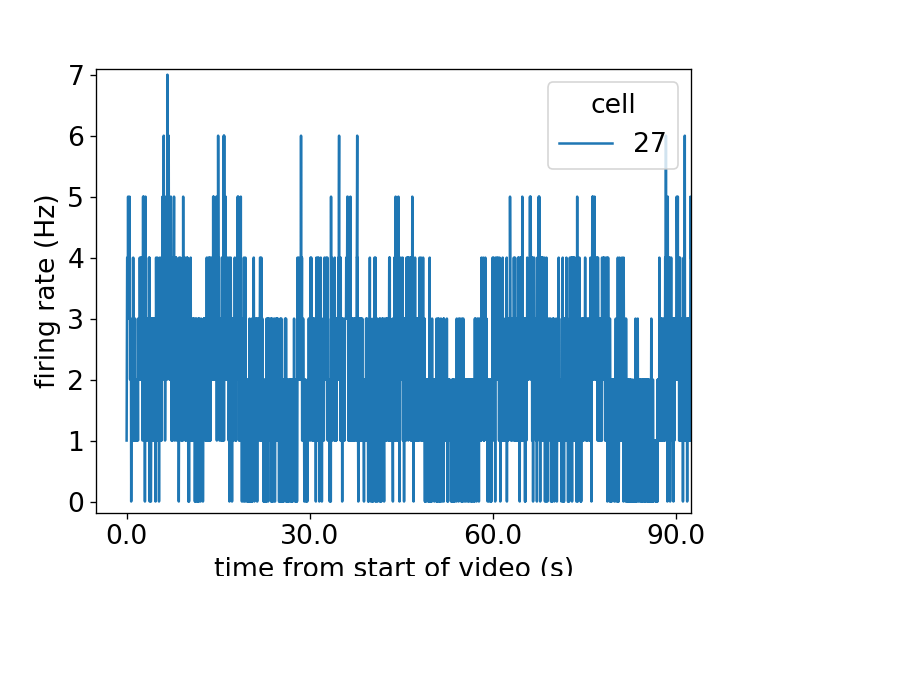

In [181]:
plt.plot(responses[:, 27])
ticks = np.linspace(0, num_bins, 11).astype(int)
plt.xticks(ticks)
ax = plt.gca()
ax.set_xticklabels(np.round(bin_edges[ticks], 1))
plt.ylabel("firing rate (Hz)")
plt.xlabel("time from start of video (s)")
plt.title("")
plt.legend(title="cell", labels=[27], loc="upper right")

In [217]:
unit_idx = 27
x = responses[:, unit_idx].reshape(-1, 1)
x.shape

(10000, 1)

In [218]:
x_original = x

In [139]:
data_name = f"neuralCell{unit_idx}Nat1[Poisson]"

train_through = 7000
train_start = 0
delay = 0
test_length = 5000
x = x[train_start:]
predict_through = train_through + test_length + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [1,]
num_fourier = 1
hard_code = [x.shape[0] / num_presentations]
print("x", x.shape)
print("xt", xt.shape)

x (10000, 1)
xt (7000, 1)


In [220]:
model = PoissonNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [75]:
k.find_fourier_omegas(xt, hard_code=hard_code)

fourier periods: tensor([999.9999], dtype=torch.float64)


tensor([0.0063], dtype=torch.float64)

In [79]:
k.fit(xt, iterations=600, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5276448872008288
Iteration  1
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.527365394586764
Iteration  2
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5269957091411184
Iteration  3
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5277483018152271
Iteration  4
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5267105871124718
Iteration  5
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.527475468155
Iteration  6
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.527191421552716
Iteration  7
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5265354818809105
Iteration  8
tensor([999.9999])
Setting period

Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.52572569265912
Iteration  69
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5265413166841293
Iteration  70
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5262929154322873
Iteration  71
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5263028880774256
Iteration  72
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5264546453218184
Iteration  73
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5268373979437986
Iteration  74
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5263172377575822
Iteration  75
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.526351599853124
Iteration  76
tensor([999.9999])
Setting periods to tensor([999.9999

Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.525649753531865
Iteration  137
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5253321326646994
Iteration  138
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5255414633720308
Iteration  139
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5253538916590035
Iteration  140
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5257228865447507
Iteration  141
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5256208508485667
Iteration  142
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5254343291222736
Iteration  143
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5254568116106042
Iteration  144
tensor([999.9999])
Setting periods to tensor

Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.52446332643385
Iteration  205
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.524287306721989
Iteration  206
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5244113335826286
Iteration  207
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.524870742712224
Iteration  208
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5246495971466858
Iteration  209
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5247266052068058
Iteration  210
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5245367227571647
Iteration  211
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5246776199055663
Iteration  212
tensor([999.9999])
Setting periods to tensor([9

Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5240054208480196
Iteration  273
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.524260441037734
Iteration  274
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5243430145375767
Iteration  275
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5239596915085696
Iteration  276
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5240235396825064
Iteration  277
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5236954124044155
Iteration  278
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5240330289234394
Iteration  279
tensor([999.9999])
Setting periods to tensor([999.9999], grad_fn=<MulBackward0>)
Loss:  1.5243935270135054
Iteration  280
tensor([999.9999])
Setting periods to tensor

In [80]:
lam_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}lam.npy"
params = k.predict(predict_through)
rate_hat, = params
np.save(lam_file, rate_hat)

In [221]:
params = rate_hat,
mean_hat = model.mean(params)
std_hat = model.std(params)

<IPython.core.display.Javascript object>


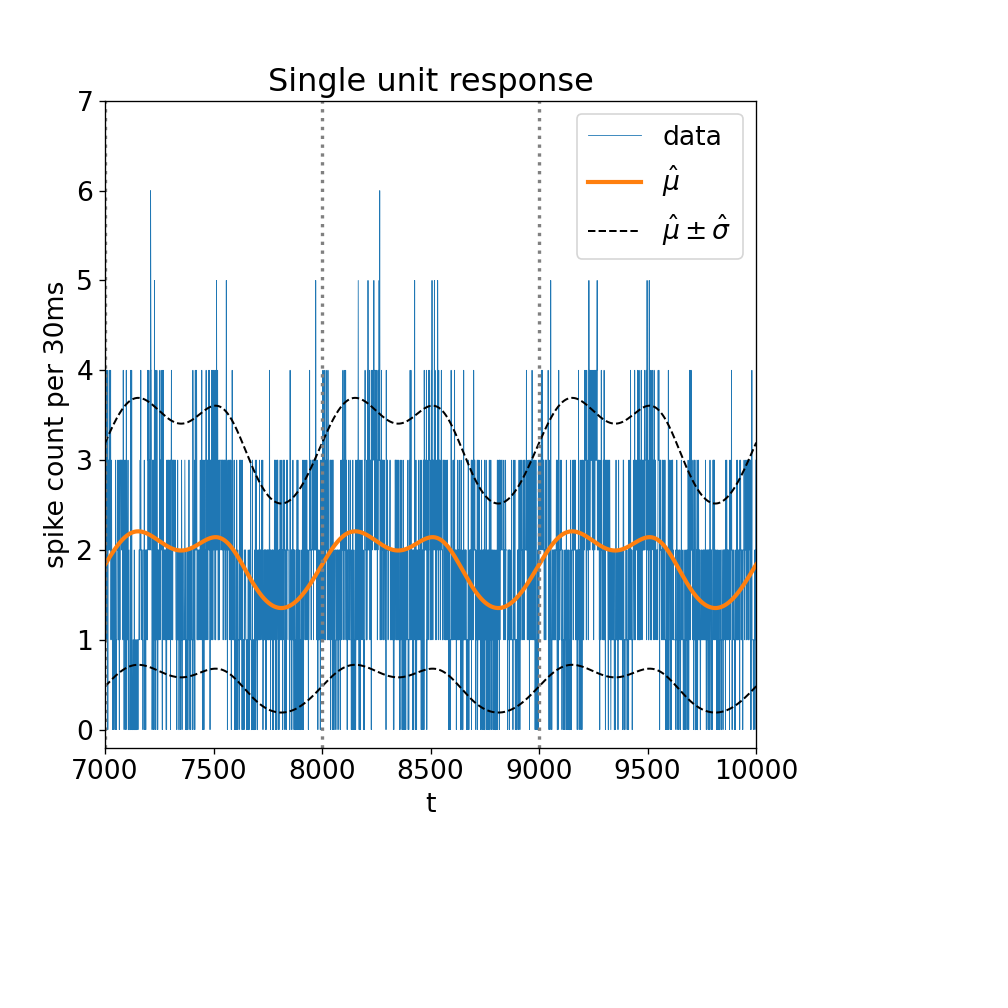

In [165]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
dim = 0
plt.subplots(figsize=[7, 7], dpi=100)
plt.subplot(111)
plt.plot(x[:predict_through, dim], linewidth=0.5, label="data")
plt.plot(mean_hat[:, dim], label="$\hat \mu$", linewidth=2.5)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--k", label="$\hat \mu \pm \hat \sigma$", linewidth=1.2)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--k", linewidth=1.2)
# plt.plot(2 * std_hat[:, dim], "-.g", linewidth=2.5, label="uncertainty ($2\hat \sigma$)")
plt.axvline(7000, linestyle=":", color="gray", linewidth=2)
plt.axvline(8000, linestyle=":", color="gray", linewidth=2)
plt.axvline(9000, linestyle=":", color="gray", linewidth=2)
# plt.axhline(0, color="k")

plt.title("Single unit response")
plt.xlabel("t")
plt.ylabel("spike count per 30ms")
plt.legend(loc="upper right")
plt.xlim([7000, 10000])
plt.ylim([-0.2, 7])
plt.show()

In [222]:
idx = train_through
residuals = mean_hat[idx:idx + 3000, 0] - x[idx:idx+3000, 0]
fano_factors = residuals ** 2 / mean_hat[idx:idx+3000, 0]  # poisson assumes variance equals mean
np.mean(fano_factors), fano_factors

(0.594573371464733,
 array([0.01480453, 0.01405763, 0.38576095, ..., 0.01717573, 0.37440885,
        0.74612438]))

In [223]:
np.std(x[idx:idx+3000, 0])**2 / np.mean(x[idx:idx+3000, 0])  # usual calculation of fano factor

0.6517431256747316

# Run on first PCA mode

In [171]:
Xc = responses - np.mean(responses, axis=0, keepdims=True)
U, S, Vh = np.linalg.svd(Xc, full_matrices=False)
proj_rank = 1
x = -(np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
x

array([[-1.2633573 ],
       [-0.70385658],
       [-0.60549482],
       ...,
       [-0.81507145],
       [-1.32356234],
       [-0.36821847]])

<IPython.core.display.Javascript object>


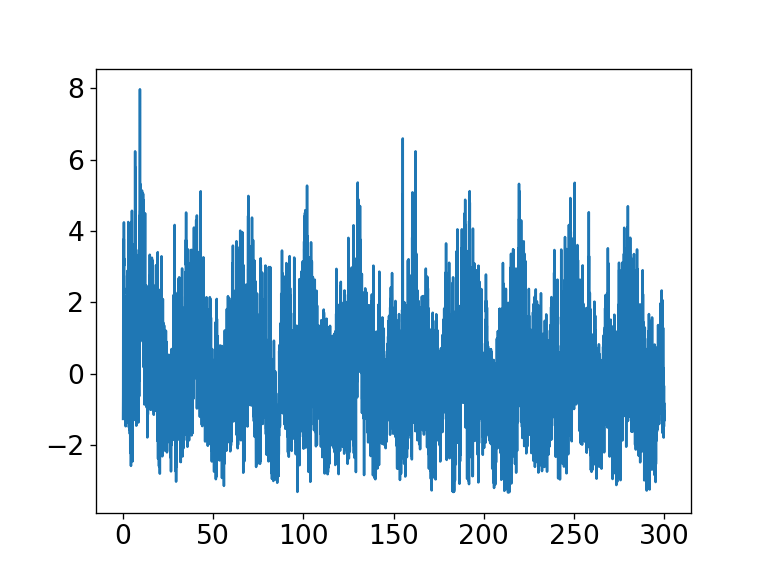

In [172]:
%matplotlib notebook
plt.plot(bin_centers, X)

In [174]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.matlib.repmat(rnge, x.shape[0], 1)
print("x", x.shape)

x (10000, 1)


In [175]:
data_name = "neuralPCA1_Nat1[SkewNorm]"

train_through = 7000
train_start = 0
delay = 0
test_length = 5000
x = x[train_start:]
predict_through = train_through + test_length + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [1, 1, 1]
num_fourier = 1
hard_code = [x.shape[0] / num_presentations]
print("x", x.shape)
print("xt", xt.shape)

x (10000, 1)
xt (7000, 1)


In [176]:
model = SkewNormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [50]:
k.find_fourier_omegas(xt, hard_code=hard_code)

fourier periods: tensor([999.9999], dtype=torch.float64)


tensor([0.0063], dtype=torch.float64)

In [51]:
k.fit(xt, iterations=300, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  2.605638461335936
Iteration  1
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  2.4520434432823275
Iteration  2
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  2.2828121944023403
Iteration  3
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  2.09384714180723
Iteration  4
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  1.880340402264316
Iteration  5
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  1.6373010733020015
Iteration  6
tensor([999.9999, 999.9999, 999

Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9723896502937168
Iteration  52
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9719783840516872
Iteration  53
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.972542806229922
Iteration  54
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9728052762491226
Iteration  55
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9737337814005841
Iteration  56
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9736264615297716
Iteration  57
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([99

Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9813206224618742
Iteration  103
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9840806882743465
Iteration  104
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9824736190306342
Iteration  105
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9826450764835923
Iteration  106
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9829718884763039
Iteration  107
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9822272521592943
Iteration  108
tensor([999.9999, 999.9999, 999.9999])
Setting periods to ten

Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.988383135529238
Iteration  154
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9868295809627182
Iteration  155
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.98752739408867
Iteration  156
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9873985271930443
Iteration  157
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.986920187433218
Iteration  158
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9888420372752219
Iteration  159
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor(

Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9895418425284404
Iteration  205
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9894691700001832
Iteration  206
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9901559206116151
Iteration  207
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9890813138142269
Iteration  208
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9910671738386779
Iteration  209
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9900505803740877
Iteration  210
tensor([999.9999, 999.9999, 999.9999])
Setting periods to ten

Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9905920645395099
Iteration  256
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9909908486817292
Iteration  257
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9913240409311374
Iteration  258
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9892165547180366
Iteration  259
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.9913520142225467
Iteration  260
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tensor([999.9999, 999.9999, 999.9999], grad_fn=<MulBackward0>)
Loss:  -0.991544255950178
Iteration  261
tensor([999.9999, 999.9999, 999.9999])
Setting periods to tens

In [52]:
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
params = k.predict(predict_through)
mu_hat, sigma_hat, a_hat = params
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)

In [177]:
params = mu_hat, sigma_hat, a_hat
mean_hat = model.mean(params)
std_hat = model.std(params)

<IPython.core.display.Javascript object>


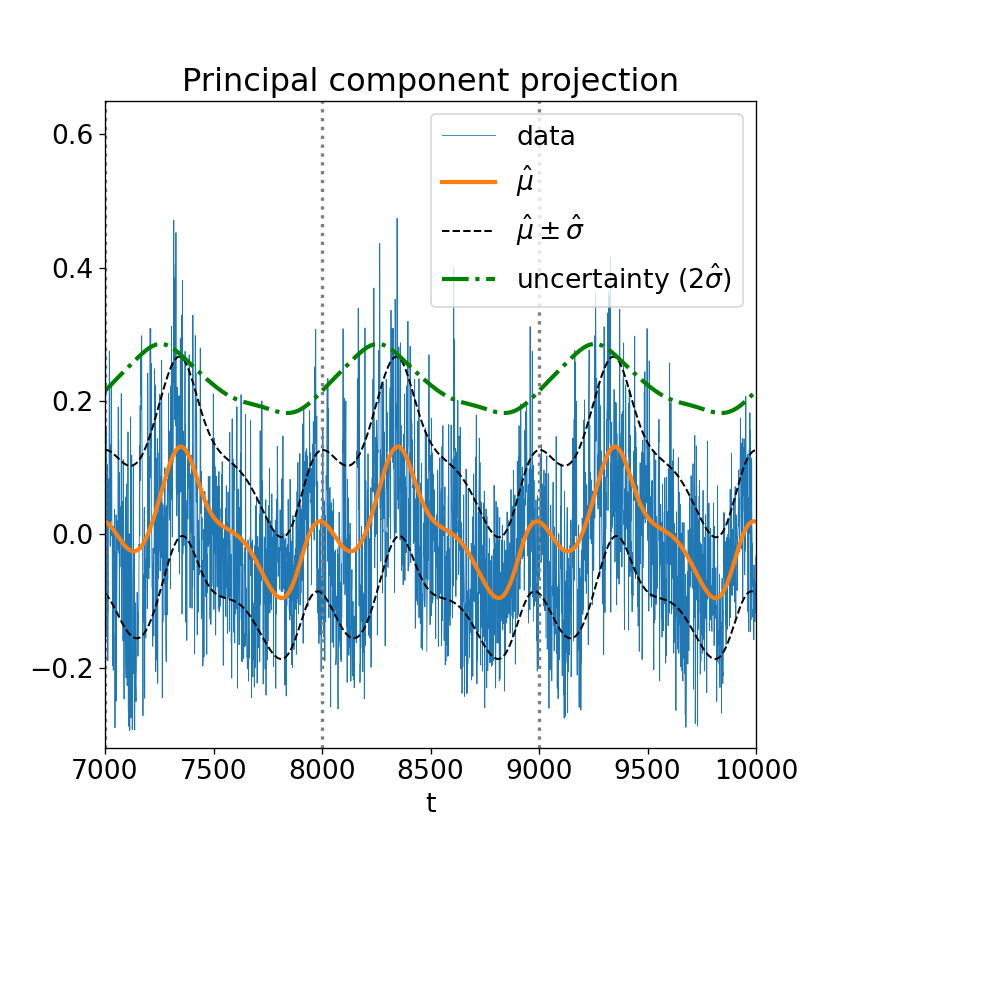

In [135]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
dim = 0
plt.subplots(figsize=[7, 7], dpi=100)
plt.subplot(111)
plt.plot(x[:predict_through, dim], linewidth=0.5, label="data")
plt.plot(mean_hat[:, dim], label="$\hat \mu$", linewidth=2.5)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--k", label="$\hat \mu \pm \hat \sigma$", linewidth=1.2)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--k", linewidth=1.2)
plt.plot(2 * std_hat[:, dim], "-.g", linewidth=2.5, label="uncertainty ($2\hat \sigma$)")
plt.axvline(7000, linestyle=":", color="gray", linewidth=2)
plt.axvline(8000, linestyle=":", color="gray", linewidth=2)
plt.axvline(9000, linestyle=":", color="gray", linewidth=2)

plt.title("Principal component projection")
plt.xlabel("t")
plt.legend(loc="upper right")
plt.xlim([7000, 10000])
plt.ylim([-0.32, 0.65])
plt.show()